<a href="https://colab.research.google.com/github/MPGarg/ERA1_Session7/blob/main/ERA1S7E2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Attempt 2:**

Target:
*   Lower number of parameters (Near to our target of <=8000 Parameters)
*   Batch-norm to increase model efficiency
*   DropOut to avoid overfitting
*   Add GAP Layer and remove last big kernel

Results:
*   Total Parameters: 12,862
*   Best Training Accuracy: 98.94%
*   Best Test Accuracy: 99.05%

Analysis:
*   Model learned well and can do better if pushed to more epochs. But with current capacity it is not possible to push further.
*   Introducing Batch Normalization has helped the model in learning even with reduced parameters.
*   DropOut made the model resilient and we got Testing accuracy better than Training accuracy.
*   GAP layer has not reduced accuracy (size of 8 is used in model)
*   More regularization techniques are needed to make this work with even fewer parameters and have to achieve higher test accuracy!

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Transformations

*   Image Normalization


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 93821560.98it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 21771332.46it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27572686.01it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7019354.74it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
#Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create.
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


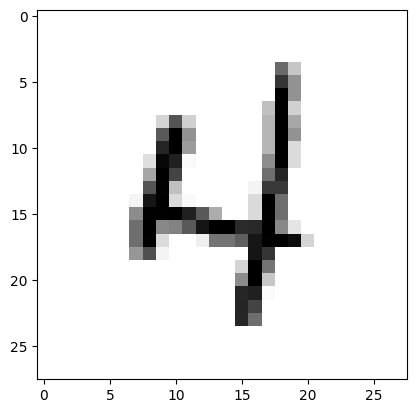

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## More Images

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

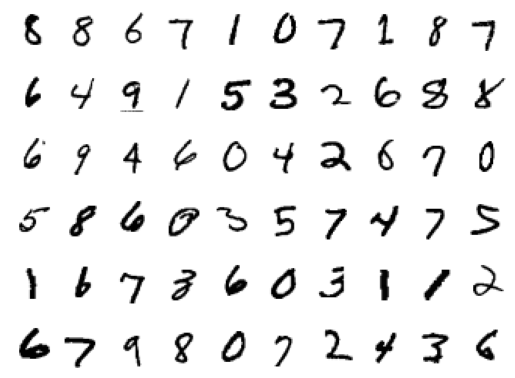

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model

In [7]:
import model2
import utils

from model2 import *
from utils import *

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
       BatchNorm2d-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,640
       BatchNorm2d-6           [-1, 32, 24, 24]              64
              ReLU-7           [-1, 32, 24, 24]               0
           Dropout-8           [-1, 32, 24, 24]               0
         MaxPool2d-9           [-1, 32, 12, 12]               0
           Conv2d-10           [-1, 16, 12, 12]             528
      BatchNorm2d-11           [-1, 16, 12, 12]              32
             ReLU-12           [-1, 16, 12, 12]               0
           Conv2d-13           [-1, 16, 10, 10]           2,320
      BatchNorm2d-14           [-1

# Training and Testing

We have 12.8k params for this model

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

# Train and Test of our model

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1 )
    train(model, device, train_loader, optimizer, epoch,train_losses, train_acc)
    test(model, device, test_loader,test_losses, test_acc)

EPOCH: 1


Loss=0.2555639445781708 Batch_id=468 Accuracy=84.26: 100%|██████████| 469/469 [00:19<00:00, 23.48it/s]



Test set: Average loss: 0.2918, Accuracy: 9620/10000 (96.20%)

EPOCH: 2


Loss=0.21036136150360107 Batch_id=468 Accuracy=96.44: 100%|██████████| 469/469 [00:18<00:00, 25.34it/s]



Test set: Average loss: 0.1831, Accuracy: 9669/10000 (96.69%)

EPOCH: 3


Loss=0.13613271713256836 Batch_id=468 Accuracy=97.33: 100%|██████████| 469/469 [00:20<00:00, 22.84it/s]



Test set: Average loss: 0.1118, Accuracy: 9804/10000 (98.04%)

EPOCH: 4


Loss=0.16179010272026062 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:22<00:00, 20.66it/s]



Test set: Average loss: 0.1106, Accuracy: 9776/10000 (97.76%)

EPOCH: 5


Loss=0.0951700508594513 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:18<00:00, 25.26it/s]



Test set: Average loss: 0.0910, Accuracy: 9810/10000 (98.10%)

EPOCH: 6


Loss=0.07729467004537582 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:19<00:00, 23.73it/s]



Test set: Average loss: 0.0883, Accuracy: 9793/10000 (97.93%)

EPOCH: 7


Loss=0.09467976540327072 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:19<00:00, 23.61it/s]



Test set: Average loss: 0.0605, Accuracy: 9880/10000 (98.80%)

EPOCH: 8


Loss=0.06861475855112076 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:18<00:00, 25.09it/s]



Test set: Average loss: 0.0582, Accuracy: 9874/10000 (98.74%)

EPOCH: 9


Loss=0.052663665264844894 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:19<00:00, 23.76it/s]



Test set: Average loss: 0.0551, Accuracy: 9879/10000 (98.79%)

EPOCH: 10


Loss=0.08267184346914291 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:19<00:00, 24.68it/s]



Test set: Average loss: 0.0533, Accuracy: 9873/10000 (98.73%)

EPOCH: 11


Loss=0.02431369759142399 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:18<00:00, 25.28it/s]



Test set: Average loss: 0.0490, Accuracy: 9886/10000 (98.86%)

EPOCH: 12


Loss=0.06273738294839859 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:21<00:00, 21.88it/s]



Test set: Average loss: 0.0494, Accuracy: 9889/10000 (98.89%)

EPOCH: 13


Loss=0.05779023841023445 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:19<00:00, 24.27it/s]



Test set: Average loss: 0.0427, Accuracy: 9893/10000 (98.93%)

EPOCH: 14


Loss=0.03528447076678276 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:19<00:00, 24.33it/s]



Test set: Average loss: 0.0404, Accuracy: 9904/10000 (99.04%)

EPOCH: 15


Loss=0.05026616156101227 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:20<00:00, 23.24it/s]



Test set: Average loss: 0.0474, Accuracy: 9882/10000 (98.82%)



In [11]:
train_losses1 = [t.cpu().item() for t in train_losses]

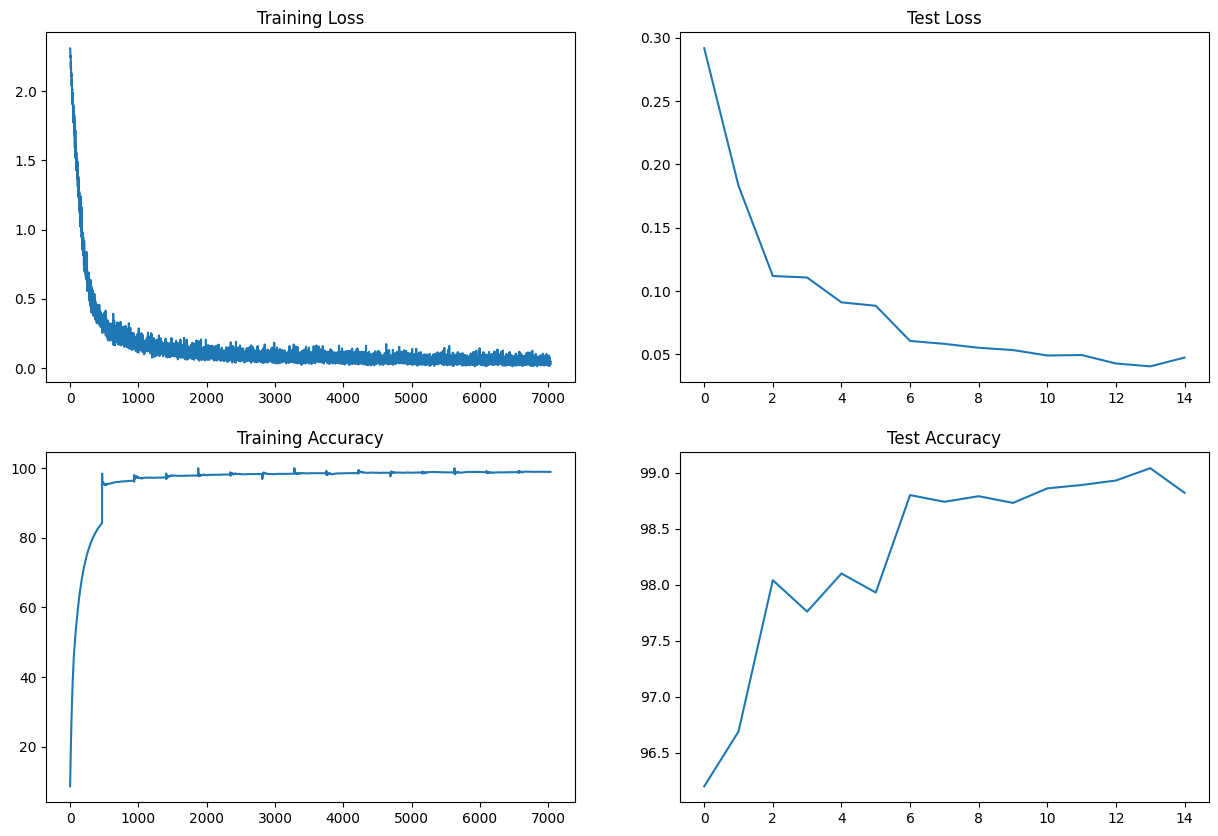

In [12]:
print_graph(train_losses1,train_acc, test_losses,test_acc)